In [ ]:
# 1.
# Install necessary packages
!pip install nba_api pandas matplotlib seaborn scikit-learn numpy
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.9/284.9 kB 2.1 MB/s eta 0:00:00


In [ ]:
# 2.
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nba_api.stats.endpoints import shotchartdetail, playergamelog, commonteamroster, teamgamelog, leaguedashteamstats
from nba_api.stats.static import players, teams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_absolute_error, mean_squared_error
import requests
from bs4 import BeautifulSoup, Comment
import matplotlib.patches as patches
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import ipywidgets as widgets
from IPython.display import display, clear_output
from google.colab import files
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier


# Print confirmation and library versions
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)


Pandas version: 2.2.2
NumPy version: 2.0.2


In [ ]:
#3
# Step 1: Get Timberwolves Team ID
team_name = 'Minnesota Timberwolves'
nba_teams = teams.get_teams()
wolves = [team for team in nba_teams if team['full_name'] == team_name][0]
team_id = wolves['id']

# Step 2: Get Timberwolves Roster for the Season
season = '2024-25'
roster = commonteamroster.CommonTeamRoster(team_id=team_id, season=season).get_data_frames()[0]

# Step 3: Loop through players and collect shot data
all_shots = []

for i, row in roster.iterrows():
    player_id = row['PLAYER_ID']
    player_name = row['PLAYER']
    print(f"Fetching shots for {player_name}...")

    try:
        shot_data = shotchartdetail.ShotChartDetail(
            team_id=team_id,
            player_id=player_id,
            season_type_all_star='Regular Season',
            season_nullable=season,
            context_measure_simple='FGA'
        ).get_data_frames()[0]

        shot_data['PLAYER_NAME'] = player_name
        all_shots.append(shot_data)

        time.sleep(1)
    except Exception as e:
        print(f"Error for {player_name}: {e}")
        continue

# Step 4: Combine all shot data into one DataFrame
shot_data_team = pd.concat(all_shots, ignore_index=True)


print(f"\nScraped {len(shot_data_team)} total shots for the Timberwolves.")

Fetching shots for Terrence Shannon Jr....
Fetching shots for Donte DiVincenzo...
Fetching shots for Jaden McDaniels...
Fetching shots for Rob Dillingham...
Fetching shots for Anthony Edwards...
Fetching shots for Joe Ingles...
Fetching shots for Josh Minott...
Fetching shots for Nickeil Alexander-Walker...
Fetching shots for Mike Conley...
Fetching shots for Naz Reid...
Fetching shots for Tristen Newton...
Fetching shots for Jesse Edwards...
Fetching shots for Jaylen Clark...
Fetching shots for Rudy Gobert...
Fetching shots for Julius Randle...
Fetching shots for Leonard Miller...
Fetching shots for Luka Garza...
Fetching shots for Bones Hyland...

Scraped 7178 total shots for the Timberwolves.


In [ ]:
#4
#Step 1: Get Team ID
team_name = 'New York Knicks'
nba_teams = teams.get_teams()
knicks = [team for team in nba_teams if team['full_name'] == team_name][0]
team_id = knicks['id']


season = '2024-25'
roster = commonteamroster.CommonTeamRoster(team_id=team_id, season=season).get_data_frames()[0]


all_shots = []

for i, row in roster.iterrows():
    player_id = row['PLAYER_ID']
    player_name = row['PLAYER']
    print(f"Fetching shots for {player_name}...")

    try:
        shot_data = shotchartdetail.ShotChartDetail(
            team_id=team_id,
            player_id=player_id,
            season_type_all_star='Regular Season',
            season_nullable=season,
            context_measure_simple='FGA'
        ).get_data_frames()[0]

        shot_data['PLAYER_NAME'] = player_name
        all_shots.append(shot_data)

        time.sleep(1)  #
    except Exception as e:
        print(f"Error for {player_name}: {e}")
        continue


shot_data_ny = pd.concat(all_shots, ignore_index=True)


print(f"\nScraped {len(shot_data_ny)} total shots for the Knicks.")


Fetching shots for Delon Wright...
Fetching shots for MarJon Beauchamp...
Fetching shots for P.J. Tucker...
Fetching shots for Cameron Payne...
Fetching shots for Miles McBride...
Fetching shots for Josh Hart...
Fetching shots for Pacôme Dadiet...
Fetching shots for Precious Achiuwa...
Fetching shots for OG Anunoby...
Fetching shots for Kevin McCullar Jr....
Fetching shots for Jalen Brunson...
Fetching shots for Tyler Kolek...
Fetching shots for Mitchell Robinson...
Fetching shots for Mikal Bridges...
Fetching shots for Anton Watson...
Fetching shots for Karl-Anthony Towns...
Fetching shots for Landry Shamet...
Fetching shots for Ariel Hukporti...

Scraped 7228 total shots for the Knicks.


In [ ]:
#5
# Select and rename relevant columns for easier handling
shot_data_clean = shot_data_team[[
    'GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG',
       'HTM', 'VTM'
]].copy()

# Check for any missing values
missing_values = shot_data_clean.isnull().sum()
print("Missing values per column:\n", missing_values)

# Display a preview of cleaned data
print("\nCleaned shot data preview:")
shot_data_clean.head()


Missing values per column:
 GRID_TYPE              0
GAME_ID                0
GAME_EVENT_ID          0
PLAYER_ID              0
PLAYER_NAME            0
TEAM_ID                0
TEAM_NAME              0
PERIOD                 0
MINUTES_REMAINING      0
SECONDS_REMAINING      0
EVENT_TYPE             0
ACTION_TYPE            0
SHOT_TYPE              0
SHOT_ZONE_BASIC        0
SHOT_ZONE_AREA         0
SHOT_ZONE_RANGE        0
SHOT_DISTANCE          0
LOC_X                  0
LOC_Y                  0
SHOT_ATTEMPTED_FLAG    0
SHOT_MADE_FLAG         0
HTM                    0
VTM                    0
dtype: int64

Cleaned shot data preview:


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,HTM,VTM
0,Shot Chart Detail,0022400162,623,1630545,Terrence Shannon Jr.,1610612750,Minnesota Timberwolves,4,4,38,...,Left Corner 3,Left Side(L),24+ ft.,22,-223,-4,1,0,MIN,CHA
1,Shot Chart Detail,0022400181,631,1630545,Terrence Shannon Jr.,1610612750,Minnesota Timberwolves,4,1,19,...,Restricted Area,Center(C),Less Than 8 ft.,0,-2,7,1,1,CHI,MIN
2,Shot Chart Detail,0022400181,647,1630545,Terrence Shannon Jr.,1610612750,Minnesota Timberwolves,4,0,31,...,Restricted Area,Center(C),Less Than 8 ft.,1,2,12,1,1,CHI,MIN
3,Shot Chart Detail,0022400318,558,1630545,Terrence Shannon Jr.,1610612750,Minnesota Timberwolves,4,5,20,...,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,-2,41,1,0,MIN,LAL
4,Shot Chart Detail,0022400318,606,1630545,Terrence Shannon Jr.,1610612750,Minnesota Timberwolves,4,1,17,...,Right Corner 3,Right Side(R),24+ ft.,23,237,27,1,1,MIN,LAL


In [ ]:
#6
# Select and rename relevant columns for easier handling
shot_data_clean_ny = shot_data_ny[[
    'GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
    'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
    'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
    'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
    'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG',
    'HTM', 'VTM'
]].copy()


target_players = [
    'Donte DiVincenzo', 'Jacob Toppin', 'Miles McBride', 'Josh Hart',
    'Charlie Brown Jr.', 'Precious Achiuwa', 'OG Anunoby',
    'DaQuan Jeffries', 'Jalen Brunson', 'Shake Milton', 'Alec Burks',
    'Mamadi Diakite', 'Mitchell Robinson', 'Julius Randle',
    'Bojan Bogdanovi\u0107', 'Jericho Sims', 'Isaiah Hartenstein'
]

# Filter the dataframe to only include shots from target players
shot_data_clean_ny = shot_data_clean_ny[shot_data_clean_ny['PLAYER_NAME'].isin(target_players)].copy()

# Check for any missing values
missing_values = shot_data_clean_ny.isnull().sum()
print("Missing values per column:\n", missing_values)

# Display a preview of cleaned data
print("\nCleaned shot data preview:")
shot_data_clean_ny.head()

Missing values per column:
 GRID_TYPE              0
GAME_ID                0
GAME_EVENT_ID          0
PLAYER_ID              0
PLAYER_NAME            0
TEAM_ID                0
TEAM_NAME              0
PERIOD                 0
MINUTES_REMAINING      0
SECONDS_REMAINING      0
EVENT_TYPE             0
ACTION_TYPE            0
SHOT_TYPE              0
SHOT_ZONE_BASIC        0
SHOT_ZONE_AREA         0
SHOT_ZONE_RANGE        0
SHOT_DISTANCE          0
LOC_X                  0
LOC_Y                  0
SHOT_ATTEMPTED_FLAG    0
SHOT_MADE_FLAG         0
HTM                    0
VTM                    0
dtype: int64

Cleaned shot data preview:


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,HTM,VTM
513,Shot Chart Detail,0022400004,79,1630540,Miles McBride,1610612752,New York Knicks,1,5,14,...,In The Paint (Non-RA),Center(C),8-16 ft.,10,-17,105,1,1,PHI,NYK
514,Shot Chart Detail,0022400004,131,1630540,Miles McBride,1610612752,New York Knicks,1,1,6,...,Above the Break 3,Left Side Center(LC),24+ ft.,27,-197,189,1,1,PHI,NYK
515,Shot Chart Detail,0022400004,147,1630540,Miles McBride,1610612752,New York Knicks,1,0,1,...,Backcourt,Back Court(BC),Back Court Shot,52,-216,483,1,0,PHI,NYK
516,Shot Chart Detail,0022400004,196,1630540,Miles McBride,1610612752,New York Knicks,2,8,46,...,Restricted Area,Center(C),Less Than 8 ft.,1,6,13,1,1,PHI,NYK
517,Shot Chart Detail,0022400004,208,1630540,Miles McBride,1610612752,New York Knicks,2,8,17,...,In The Paint (Non-RA),Center(C),Less Than 8 ft.,5,6,53,1,1,PHI,NYK


In [ ]:
#7
team_stats = leaguedashteamstats.LeagueDashTeamStats(
    season='2024-25',
    season_type_all_star='Regular Season',
    measure_type_detailed_defense='Advanced'
)

team_df = team_stats.get_data_frames()[0]

defensive_ratings = team_df[['TEAM_NAME', 'DEF_RATING']]

print(defensive_ratings)

                 TEAM_NAME  DEF_RATING
0            Atlanta Hawks       114.8
1           Boston Celtics       110.1
2            Brooklyn Nets       115.4
3        Charlotte Hornets       115.7
4            Chicago Bulls       114.8
5      Cleveland Cavaliers       111.8
6         Dallas Mavericks       115.0
7           Denver Nuggets       115.1
8          Detroit Pistons       112.5
9    Golden State Warriors       111.0
10         Houston Rockets       110.3
11          Indiana Pacers       113.3
12             LA Clippers       109.4
13      Los Angeles Lakers       113.8
14       Memphis Grizzlies       112.6
15              Miami Heat       112.0
16         Milwaukee Bucks       112.7
17  Minnesota Timberwolves       110.8
18    New Orleans Pelicans       119.1
19         New York Knicks       113.3
20   Oklahoma City Thunder       106.6
21           Orlando Magic       109.1
22      Philadelphia 76ers       117.3
23            Phoenix Suns       117.7
24  Portland Trail Blazer

In [ ]:
#8
url = "https://www.basketball-reference.com/teams/NYK/2024.html"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Basketball Reference hides some tables inside HTML comments
comments = soup.find_all(string=lambda text: isinstance(text, Comment))

advanced_table = None

# Find the commented-out 'advanced' stats table
for comment in comments:
    if 'id="advanced"' in comment:
        advanced_table = BeautifulSoup(comment, 'html.parser').find('table', {'id': 'advanced'})
        break

if advanced_table is None:
    raise ValueError("Advanced table not found!")

# Read the table into pandas DataFrame
df = pd.read_html(str(advanced_table))[0]

# Handle multi-level column headers if present
if df.columns.nlevels > 1:
    df.columns = df.columns.get_level_values(1)

# Select defensive columns
defensive_cols = ['Player', 'G', 'MP', 'DRB%', 'STL%', 'BLK%', 'DWS', 'DBPM']
df_ny_defensive = df[defensive_cols]


# Rename columns clearly
df_ny_defensive.columns = ['Player', 'Games Played', 'Minutes Played', 'Def. Rebound %',
                        'Steal %', 'Block %', 'Def. Win Shares', 'Def. Box +/-']
df_ny_defensive=df_ny_defensive.rename(columns={'Player': 'PLAYER_NAME'})
# Remove unwanted rows like 'Team Totals'
df_ny_defensive = df_ny_defensive[df_ny_defensive['PLAYER_NAME'] != 'Team Totals']

target_players = [
    'Donte DiVincenzo', 'Jacob Toppin', 'Miles McBride', 'Josh Hart',
    'Charlie Brown Jr.', 'Precious Achiuwa', 'OG Anunoby',
    'DaQuan Jeffries', 'Jalen Brunson', 'Shake Milton', 'Alec Burks',
    'Mamadi Diakite', 'Mitchell Robinson', 'Julius Randle',
    'Bojan Bogdanović', 'Jericho Sims', 'Isaiah Hartenstein'
]

# Filter the DataFrame to only include those players
df_ny_defensive = df_ny_defensive[df_ny_defensive['PLAYER_NAME'].isin(target_players)]


# Display the defensive statistics
print(df_ny_defensive.head(17))

           PLAYER_NAME  Games Played  Minutes Played  Def. Rebound %  Steal %  \
0        Jalen Brunson            77            2726             9.7      1.3   
1            Josh Hart            81            2707            22.8      1.4   
2     Donte DiVincenzo            81            2360            11.2      2.3   
3   Isaiah Hartenstein            75            1896            22.7      2.3   
4        Julius Randle            46            1630            22.4      0.8   
5        Miles McBride            68            1328             5.9      1.9   
6     Precious Achiuwa            49            1187            19.9      1.3   
8           OG Anunoby            23             802            11.1      2.5   
9    Mitchell Robinson            31             768            17.7      2.4   
12        Jericho Sims            45             585            17.5      0.7   
13    Bojan Bogdanović            29             557             9.9      0.6   
14          Alec Burks      

<ipython-input-8-646f93087fe2>:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(advanced_table))[0]


In [ ]:
#9
nyk_data= pd.merge(df_ny_defensive, shot_data_clean_ny, on='PLAYER_NAME', how='left')
knicks_abbr = 'NYK'

# opponent column for NYK
nyk_data['OPPONENT'] = nyk_data.apply(
    lambda row: row['VTM'] if row['HTM'] == knicks_abbr else row['HTM'],
    axis=1)
nyk_data.to_csv('nyk_data.csv', index=False)

files.download('nyk_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#10
url = "https://www.basketball-reference.com/teams/MIN/2025.html"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Basketball Reference hides some tables inside HTML comments
comments = soup.find_all(string=lambda text: isinstance(text, Comment))

advanced_table = None

# Find the commented-out 'advanced' stats table
for comment in comments:
    if 'id="advanced"' in comment:
        advanced_table = BeautifulSoup(comment, 'html.parser').find('table', {'id': 'advanced'})
        break

if advanced_table is None:
    raise ValueError("Advanced table not found!")

# Read the table into pandas DataFrame
df = pd.read_html(str(advanced_table))[0]

# Handle multi-level column headers if present
if df.columns.nlevels > 1:
    df.columns = df.columns.get_level_values(1)

# Select defensive columns
defensive_cols = ['Player', 'G', 'MP', 'DRB%', 'STL%', 'BLK%', 'DWS', 'DBPM']
df_min_defensive = df[defensive_cols]


# Rename columns clearly
df_min_defensive.columns = ['Player', 'Games Played', 'Minutes Played', 'Def. Rebound %',
                        'Steal %', 'Block %', 'Def. Win Shares', 'Def. Box +/-']
df_min_defensive=df_min_defensive.rename(columns={'Player': 'PLAYER_NAME'})
# Remove unwanted rows like 'Team Totals'
df_min_defensive = df_min_defensive[df_min_defensive['PLAYER_NAME'] != 'Team Totals']

target_players = [
    'Terrence Shannon Jr.', 'Donte DiVincenzo', 'Jaden McDaniels',
       'Rob Dillingham', 'Anthony Edwards', 'Joe Ingles', 'Josh Minott',
       'Nickeil Alexander-Walker', 'Mike Conley', 'Naz Reid',
       'Tristen Newton', 'Jaylen Clark', 'Rudy Gobert', 'Julius Randle',
       'Leonard Miller', 'Luka Garza', 'Bones Hyland'
]

# Filter the DataFrame to only include those players
df_min_defensive = df_min_defensive[df_min_defensive['PLAYER_NAME'].isin(target_players)]


# Display the defensive statistics
print(df_min_defensive.head(17))


                 PLAYER_NAME  Games Played  Minutes Played  Def. Rebound %  \
0            Anthony Edwards            79            2871            14.8   
1            Jaden McDaniels            82            2614            14.2   
2                Rudy Gobert            72            2388            23.8   
3              Julius Randle            69            2226            16.8   
4                   Naz Reid            80            2200            19.3   
5   Nickeil Alexander-Walker            82            2073            11.1   
6                Mike Conley            71            1756             9.3   
7           Donte DiVincenzo            62            1606            13.3   
8               Jaylen Clark            40             522             5.6   
9             Rob Dillingham            49             516             8.0   
10      Terrence Shannon Jr.            32             339            11.9   
11               Josh Minott            46             276      

<ipython-input-10-cc514eb957a7>:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(advanced_table))[0]


In [ ]:
#11
twolves_data= pd.merge(shot_data_clean, df_min_defensive, on='PLAYER_NAME')
twolves_abbr = 'MIN'

# opponent column for MIN
twolves_data['OPPONENT'] = twolves_data.apply(
    lambda row: row['VTM'] if row['HTM'] == twolves_abbr else row['HTM'],
    axis=1
)
twolves_data.to_csv('twolves_data.csv', index=False)

files.download('twolves_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#12
twolves_data['POINTS'] = twolves_data.apply(
    lambda row: 3 if '3PT' in row['SHOT_TYPE'] and row['SHOT_MADE_FLAG'] == 1
    else 2 if '2PT' in row['SHOT_TYPE'] and row['SHOT_MADE_FLAG'] == 1
    else 0,
    axis=1
)
twolves_data['is_home'] = (twolves_data['HTM'] == 'Minnesota Timberwolves').astype(int)
twolves_data['is_clutch'] = twolves_data.apply(
    lambda row: 1 if (row['PERIOD'] >= 4 and row['SECONDS_REMAINING'] <= 5) else 0, axis=1)


player_game_stats = twolves_data.groupby(['GAME_ID', 'PLAYER_NAME']).agg(
    total_points=('POINTS', 'sum'),
    shots_made=('SHOT_MADE_FLAG', 'sum'),
    total_shots=('SHOT_MADE_FLAG', 'count'),
    avg_shot_distance=('SHOT_DISTANCE', 'mean'),
    num_3pt=('SHOT_TYPE', lambda x: (x == '3PT Field Goal').sum()),
    is_home=('is_home', 'mean'),
    clutch_shots=('is_clutch', 'sum')
).reset_index()

player_game_stats['FG_PCT'] = player_game_stats['shots_made'] / player_game_stats['total_shots']
player_game_stats['scored_15_plus'] = (player_game_stats['total_points'] > 15).astype(int)
player_game_stats['fg_above_50'] = (player_game_stats['FG_PCT'] > 0.50).astype(int)


features = ['avg_shot_distance', 'num_3pt', 'total_shots', 'is_home', 'clutch_shots']
X = player_game_stats[features]
y = player_game_stats[['scored_15_plus', 'fg_above_50']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42)

voting_ensemble = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('gb', gb_model)
], voting='soft')

multi_model = MultiOutputClassifier(voting_ensemble)
multi_model.fit(X_train, y_train)


y_pred = multi_model.predict(X_test)


print("=== Prediction: Scored > 15 Points ===")
print(classification_report(y_test['scored_15_plus'], y_pred[:, 0]))

print("=== Prediction: FG% > 50% ===")
print(classification_report(y_test['fg_above_50'], y_pred[:, 1]))


print("\nFeature Importances (FG% Prediction Model - RF):")
rf_importances = multi_model.estimators_[1].estimators_[0].feature_importances_
for feat, imp in zip(features, rf_importances):
    print(f"{feat}: {imp:.4f}")


=== Prediction: Scored > 15 Points ===
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       130
           1       0.63      0.68      0.66        28

    accuracy                           0.87       158
   macro avg       0.78      0.80      0.79       158
weighted avg       0.88      0.87      0.88       158

=== Prediction: FG% > 50% ===
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       110
           1       0.47      0.33      0.39        48

    accuracy                           0.68       158
   macro avg       0.61      0.58      0.59       158
weighted avg       0.66      0.68      0.67       158


Feature Importances (FG% Prediction Model - RF):
avg_shot_distance: 0.5322
num_3pt: 0.1852
total_shots: 0.2334
is_home: 0.0000
clutch_shots: 0.0491


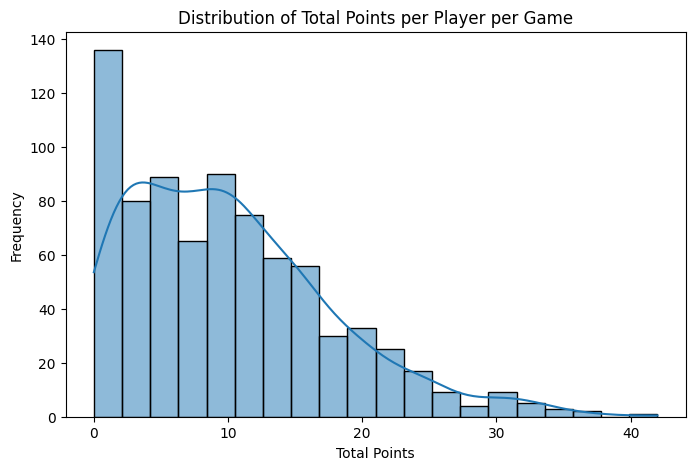

In [ ]:
 #13
 #Graph total points distribution
plt.figure(figsize=(8, 5))
sns.histplot(player_game_stats['total_points'], bins=20, kde=True)
plt.title('Distribution of Total Points per Player per Game')
plt.xlabel('Total Points')
plt.ylabel('Frequency')
plt.show()

<ipython-input-51-c8d116a7ae9d>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_stats = player_game_stats.groupby(['distance_bin', 'scored_15_plus']).agg(


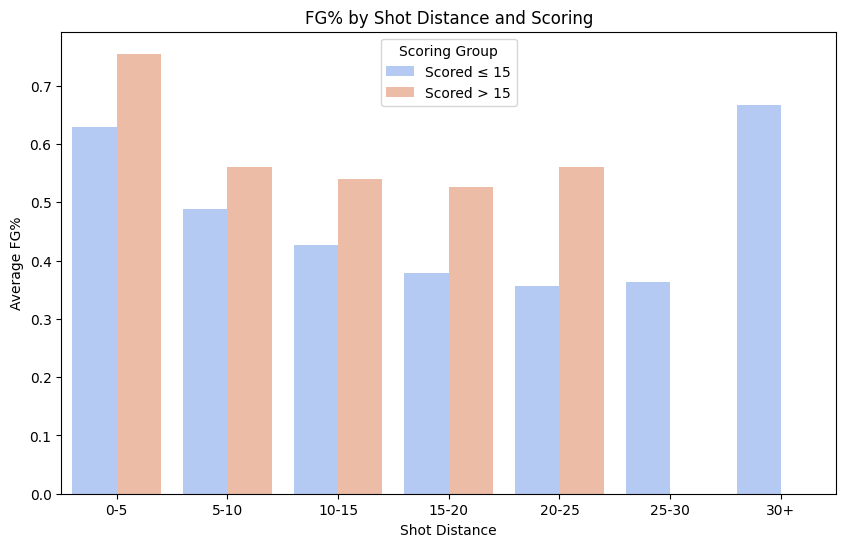

In [51]:
#14
# Bar chart of FG% by distance

bins = [0, 5, 10, 15, 20, 25, 30, 100]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30+']

player_game_stats['distance_bin'] = pd.cut(
    player_game_stats['avg_shot_distance'],
    bins=bins,
    labels=labels,
    right=False
)
agg_stats = player_game_stats.groupby(['distance_bin', 'scored_15_plus']).agg(
    FG_PCT_mean=('FG_PCT', 'mean'),
    count=('FG_PCT', 'size')
).reset_index()


agg_stats['scored_15_plus'] = agg_stats['scored_15_plus'].map({
    0: 'Scored ≤ 15',
    1: 'Scored > 15'
})

plt.figure(figsize=(10, 6))
sns.barplot(
    data=agg_stats,
    x='distance_bin',
    y='FG_PCT_mean',
    hue='scored_15_plus',
    palette='coolwarm')
plt.title('FG% by Shot Distance and Scoring')
plt.xlabel('Shot Distance')
plt.ylabel('Average FG%')
plt.legend(title='Scoring Group')

plot_filename = "fg_by_shot_distance.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()

#files.download(plot_filename)

In [48]:
#15
def simulate_matchup(shooter_name, defender_name):
    shooter_df = twolves_data[twolves_data['PLAYER_NAME'] == shooter_name].copy()
    if shooter_df.empty:
        return f"No shot data found for shooter: {shooter_name}"

    defender_row = nyk_data[nyk_data['PLAYER_NAME'] == defender_name].copy()
    if defender_row.empty:
        return f"No defensive data found for defender: {defender_name}"

    defender_metrics = ['Def. Rebound %', 'Steal %', 'Block %', 'Def. Win Shares', 'Def. Box +/-']
    for metric in defender_metrics:
        defender_row[metric] = pd.to_numeric(defender_row[metric], errors='coerce')
    defender_stats = defender_row[defender_metrics].mean()

    for col in ['LOC_X', 'LOC_Y', 'SHOT_DISTANCE']:
        shooter_df[col] = pd.to_numeric(shooter_df[col], errors='coerce')

    shooter_df['SHOT_TYPE'] = shooter_df['SHOT_TYPE'].astype(str)

    shooter_df['opp_Def. Rebound %'] = defender_stats['Def. Rebound %']
    shooter_df['opp_Steal %'] = defender_stats['Steal %']
    shooter_df['opp_Block %'] = defender_stats['Block %']
    shooter_df['opp_Def. Win Shares'] = defender_stats['Def. Win Shares']
    shooter_df['opp_Def. Box +/-'] = defender_stats['Def. Box +/-']

    shooter_df['angle_from_basket'] = np.degrees(np.arctan2(shooter_df['LOC_Y'], shooter_df['LOC_X']))
    shooter_df['POINTS'] = shooter_df['SHOT_TYPE'].apply(lambda x: 3 if '3PT' in str(x) else 2)
    shooter_df['home_game'] = shooter_df['HTM'].apply(lambda x: 1 if x == 'Minnesota Timberwolves' else 0)
    shooter_df['is_corner_three'] = shooter_df.apply(
        lambda row: 1 if (abs(row['LOC_X']) > 220 and row['LOC_Y'] < 100 and '3PT' in str(row['SHOT_TYPE'])) else 0, axis=1)
    shooter_df['is_midrange'] = shooter_df['SHOT_DISTANCE'].apply(lambda d: 1 if 10 <= d <= 18 else 0)

    zone_dummies = pd.get_dummies(shooter_df['SHOT_ZONE_BASIC'], prefix='zone')
    shooter_df = pd.concat([shooter_df, zone_dummies], axis=1)
    shooter_df = shooter_df.loc[:, ~shooter_df.columns.duplicated()].copy()

    shooter_df['dist_0-5'] = shooter_df['SHOT_DISTANCE'].apply(lambda x: 1 if 0 <= x < 5 else 0)
    shooter_df['dist_5-10'] = shooter_df['SHOT_DISTANCE'].apply(lambda x: 1 if 5 <= x < 10 else 0)

    for col in zone_cols:
        if col not in shooter_df:
            shooter_df[col] = 0

    for col in numeric_features + binary_features:
        shooter_df[col] = pd.to_numeric(shooter_df[col], errors='coerce')

    for col in categorical_features:
        shooter_df[col] = shooter_df[col].astype(str)

    shooter_df = shooter_df.dropna(subset=required_cols)

    X = shooter_df[numeric_features + binary_features + zone_cols + categorical_features]
    y = shooter_df['SHOT_MADE_FLAG'].astype('float32')

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features + binary_features + zone_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

    X_processed = preprocessor.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=0)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    total_shots = len(y_test)
    made = int(y_test.sum())
    missed = total_shots - made

    return f"\Simulated Matchup: {shooter_name} vs {defender_name}\Test Accuracy: {accuracy:.4f}\Shots Made: {made}, Shots Missed: {missed}, Total Shots: {total_shots}"

#can change shooter and defender here
simulate_matchup("Rudy Gobert", "OG Anunoby")


'\\Simulated Matchup: Rudy Gobert vs OG Anunoby\\Test Accuracy: 0.7059\\Shots Made: 61, Shots Missed: 41, Total Shots: 102'

In [56]:
#16
def simulate_matchup_with_probabilities(shooter_name, defender_name):
    shooter_df = twolves_data[twolves_data['PLAYER_NAME'] == shooter_name].copy()
    if shooter_df.empty:
        return f"No shot data found for shooter: {shooter_name}"

    defender_row = nyk_data[nyk_data['PLAYER_NAME'] == defender_name].copy()
    if defender_row.empty:
        return f"No defensive data found for defender: {defender_name}"

    defender_metrics = ['Def. Rebound %', 'Steal %', 'Block %', 'Def. Win Shares', 'Def. Box +/-']
    for metric in defender_metrics:
        defender_row[metric] = pd.to_numeric(defender_row[metric], errors='coerce')
    defender_stats = defender_row[defender_metrics].mean()

    for col in ['LOC_X', 'LOC_Y', 'SHOT_DISTANCE']:
        shooter_df[col] = pd.to_numeric(shooter_df[col], errors='coerce')

    shooter_df['SHOT_TYPE'] = shooter_df['SHOT_TYPE'].astype(str)

    shooter_df['opp_Def. Rebound %'] = defender_stats['Def. Rebound %']
    shooter_df['opp_Steal %'] = defender_stats['Steal %']
    shooter_df['opp_Block %'] = defender_stats['Block %']
    shooter_df['opp_Def. Win Shares'] = defender_stats['Def. Win Shares']
    shooter_df['opp_Def. Box +/-'] = defender_stats['Def. Box +/-']

    shooter_df['angle_from_basket'] = np.degrees(np.arctan2(shooter_df['LOC_Y'], shooter_df['LOC_X']))
    shooter_df['POINTS'] = shooter_df['SHOT_TYPE'].apply(lambda x: 3 if '3PT' in str(x) else 2)
    shooter_df['home_game'] = shooter_df['HTM'].apply(lambda x: 1 if x == 'Minnesota Timberwolves' else 0)
    shooter_df['is_corner_three'] = shooter_df.apply(
        lambda row: 1 if (abs(row['LOC_X']) > 220 and row['LOC_Y'] < 100 and '3PT' in str(row['SHOT_TYPE'])) else 0, axis=1)
    shooter_df['is_midrange'] = shooter_df['SHOT_DISTANCE'].apply(lambda d: 1 if 10 <= d <= 18 else 0)

    zone_dummies = pd.get_dummies(shooter_df['SHOT_ZONE_BASIC'], prefix='zone')
    shooter_df = pd.concat([shooter_df, zone_dummies], axis=1)
    shooter_df = shooter_df.loc[:, ~shooter_df.columns.duplicated()].copy()

    shooter_df['dist_0-5'] = shooter_df['SHOT_DISTANCE'].apply(lambda x: 1 if 0 <= x < 5 else 0)
    shooter_df['dist_5-10'] = shooter_df['SHOT_DISTANCE'].apply(lambda x: 1 if 5 <= x < 10 else 0)

    zone_cols = [
        'zone_Above the Break 3', 'zone_Backcourt', 'zone_In The Paint (Non-RA)',
        'zone_Left Corner 3', 'zone_Mid-Range', 'zone_Restricted Area', 'zone_Right Corner 3'
    ]
    for col in zone_cols:
        if col not in shooter_df:
            shooter_df[col] = 0

    numeric_features = [
        'LOC_X', 'LOC_Y', 'angle_from_basket', 'POINTS',
        'opp_Def. Rebound %', 'opp_Steal %', 'opp_Block %',
        'opp_Def. Win Shares', 'opp_Def. Box +/-'
    ]
    binary_features = [
        'home_game', 'is_corner_three', 'is_midrange',
        'dist_0-5', 'dist_5-10'
    ]
    categorical_features = ['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']

    for col in numeric_features + binary_features:
        shooter_df[col] = pd.to_numeric(shooter_df[col], errors='coerce')
    for col in categorical_features:
        shooter_df[col] = shooter_df[col].astype(str)

    required_cols = numeric_features + binary_features + zone_cols + categorical_features + ['SHOT_MADE_FLAG']
    shooter_df = shooter_df.dropna(subset=required_cols)

    X = shooter_df[numeric_features + binary_features + zone_cols + categorical_features]
    y = shooter_df['SHOT_MADE_FLAG'].astype('float32')

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features + binary_features + zone_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

    X_processed = preprocessor.fit_transform(X)

    model = models.Sequential([
        layers.Input(shape=(X_processed.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_processed, y, epochs=25, batch_size=32, verbose=0)

    probabilities = model.predict(X_processed).flatten()
    avg_prob = probabilities.mean()
    shooter_df['predicted_fg_pct'] = probabilities
    shooter_df['COURT_ZONE'] = shooter_df['SHOT_ZONE_BASIC'] + ' – ' + shooter_df['SHOT_ZONE_AREA']

    return shooter_df
##Can change shooter and defender here
shooter_df = simulate_matchup_with_probabilities("Anthony Edwards", "Jalen Brunson")

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


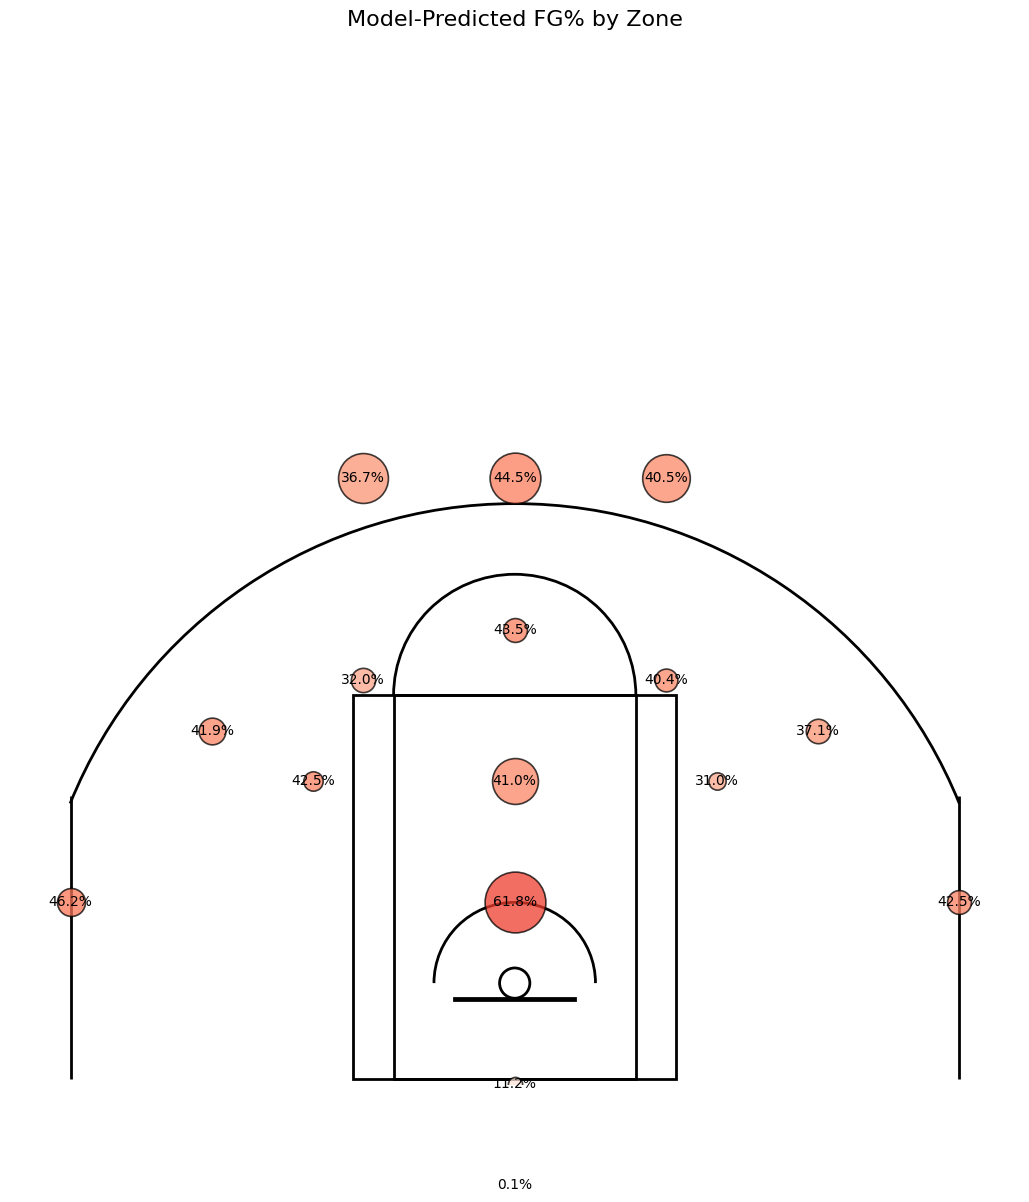

In [50]:
#17

def draw_half_court(ax=None):
    if ax is None:
        ax = plt.gca()

    hoop = patches.Circle((0, 0), radius=7.5, linewidth=2, color='black', fill=False)
    backboard = patches.Rectangle((-30, -7.5), 60, -1, linewidth=2, color='black')
    outer_box = patches.Rectangle((-80, -47.5), 160, 190, linewidth=2, color='black', fill=False)
    inner_box = patches.Rectangle((-60, -47.5), 120, 190, linewidth=2, color='black', fill=False)
    free_throw = patches.Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=2, color='black')
    restricted = patches.Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=2, color='black')
    corner_three_a = patches.Rectangle((-220, -47.5), 0, 140, linewidth=2, color='black')
    corner_three_b = patches.Rectangle((220, -47.5), 0, 140, linewidth=2, color='black')
    three_arc = patches.Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=2, color='black')

    for element in [hoop, backboard, outer_box, inner_box, free_throw, restricted,
                    corner_three_a, corner_three_b, three_arc]:
        ax.add_patch(element)


zone_coords = {
    'Restricted Area – Center(C)': (0, 40),
    'In The Paint (Non-RA) – Center(C)': (0, 100),
    'In The Paint (Non-RA) – Left Side(L)': (-100, 100),
    'In The Paint (Non-RA) – Right Side(R)': (100, 100),

    'Mid-Range – Left Side(L)': (-150, 125),
    'Mid-Range – Left Side Center(LC)': (-75, 150),
    'Mid-Range – Center(C)': (0, 175),
    'Mid-Range – Right Side Center(RC)': (75, 150),
    'Mid-Range – Right Side(R)': (150, 125),

    'Left Corner 3 – Left Side(L)': (-220, 40),
    'Right Corner 3 – Right Side(R)': (220, 40),

    'Above the Break 3 – Left Side Center(LC)': (-75, 250),
    'Above the Break 3 – Center(C)': (0, 250),
    'Above the Break 3 – Right Side Center(RC)': (75, 250),

    'Backcourt – Back Court(BC)': (0, -100),
    'Above the Break 3 – Back Court(BC)': (0, -50),
}

# Group by COURT_ZONE
zone_pred = shooter_df.groupby('COURT_ZONE').agg(
    predicted_fg_pct=('predicted_fg_pct', 'mean'),
    count=('predicted_fg_pct', 'count')
).reset_index()

# Map court coordinates
zone_pred['x'] = zone_pred['COURT_ZONE'].map(lambda z: zone_coords.get(z, (None, None))[0])
zone_pred['y'] = zone_pred['COURT_ZONE'].map(lambda z: zone_coords.get(z, (None, None))[1])
zone_pred = zone_pred.dropna(subset=['x', 'y'])

# === Plot ===
fig, ax = plt.subplots(figsize=(13, 12))

draw_half_court(ax)

for _, row in zone_pred.iterrows():
    x, y = row['x'], row['y']
    fg_pct = row['predicted_fg_pct']
    attempts = row['count']

    color = plt.cm.Reds(fg_pct)
    size = 100 + 5 * attempts

    ax.scatter(x, y, s=size, color=color, alpha=0.75, edgecolor='black', linewidth=1.2)
    ax.text(x, y, f"{fg_pct:.1%}", ha='center', va='center', fontsize=10, color='black')

ax.set_title("Model-Predicted FG% by Zone", fontsize=16)
ax.set_xlim(-250, 250)
ax.set_ylim(-50, 470)
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.show()
